# Double DK rumour spreading model


This model uses [graph-tool](https://graph-tool.skewed.de/) to efficiently support graph drawing at scale (~4000 nodes). [Unfortunately, graph tool does not support being installed through pip.](https://graph-tool.skewed.de/installation.html#native-installation)

To run this model, use the following instructions:
1. Install your python environment manager. If you don't have one, we recommend installing micromamba.
2. Set up your environment by running `micromamba env create --name compmodelling-dk -c conda-forge networkx graph-tool ipykernel`. If using conda or mamba, swap out 'micromamba' for the respective environment manager name.
3. Make sure your software reading this .ipynb file is using your compmodelling-dk python version. (Hint: use `which python` while in your environment to see where your python version is located). You may need to reload during this step for your software to recognise the environment.
4. When you're finished with your environment, remove it by running `micromamba env remove compmodelling-dk`.

In [13]:
import networkx as nx
from graph_tool.all import Graph, graph_draw, sfdp_layout, closeness, label_components
import matplotlib.pyplot as plt
import numpy as np
from enum import Enum
from typing import Self
from IPython.display import clear_output

class State(Enum):
    IGNORANT = 0 # People who haven't encountered the rumour
    RUMOUR_SPREADER = 1 # People actively spreading the rumour
    RUMOUR_CONTAINER = 2 # People who have heard the rumour but are not spreading it
    TRUTH_SPREADER = 3 # People actively spreading the truth
    TRUTH_CONTAINER = 4 # People who have heard the truth but are not spreading it

STATUS_COLOURS = {
    State.IGNORANT: 'blue',
    State.RUMOUR_SPREADER: 'orange',
    State.RUMOUR_CONTAINER: 'red',
    State.TRUTH_SPREADER: 'darkgreen',
    State.TRUTH_CONTAINER: 'lawngreen'
}

TIME_STEPS = 25
POPULATION_SIZE = 4039
CLUSTERING_COEFFICIENT = 44

ACTIVENESS = 0.1
RUMOUR_ACCEPTANCE_PROB = 0.4
TRUTH_ACCEPTANCE_PROB = 0.7

SPREADER_SPREADER_STIFLE_PROB = 0.1
SPREADER_STIFLER_STIFLE_PROB = 0.1

FORGET_PROB = 0.01


CONTROLLER_CREDIBILITY = 0.7

class ControllerConnectionStrategies(Enum):
    RANDOM = 0
    COMMUNITIES = 1

CONTROLLER_CONNECTION_STRATEGIES = ControllerConnectionStrategies.RANDOM
CCS_RANDOM_NODES = 50
CCS_COMMUNITIES_NUM = 3
CCS_COMMUNITIES_SIZE = 20

In [14]:
class Person:
    def __init__(self: Self) -> None:
        self.state = State.IGNORANT
        self.contacted = []

        self.credibility = np.clip(np.random.normal(0.5, 0.1), 0, 1) # Mean of 0.5, std dev of 0.1, restricted to [0, 1]
        self.conviction = 0.1

    def spread_rumour(self: Self, neighbour: list) -> None:
        # Checks the nodes are active and haven't already contacted each other
        if neighbour in self.contacted:
            return
        if np.random.random() > ACTIVENESS:
            return

        # Add each other to the contacted list so they don't contact each other again this time step
        self.contacted.append(neighbour)
        neighbour.contacted.append(self)

        # If neighbour is ignorant
        if neighbour.state == State.IGNORANT:
            convincing_power = self.credibility * RUMOUR_ACCEPTANCE_PROB
            resistance = neighbour.conviction
            conversion_prob = convincing_power / (convincing_power + resistance)
            if np.random.random() < conversion_prob:
                neighbour.state = State.RUMOUR_SPREADER
                neighbour.conviction = conversion_prob
        # If neighbour is a spreader
        elif neighbour.state == State.RUMOUR_SPREADER:
            self.conviction += (1 - self.conviction) * neighbour.credibility
            neighbour.conviction += (1 - neighbour.conviction) * self.credibility
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                neighbour.state = State.RUMOUR_CONTAINER
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                self.state = State.RUMOUR_CONTAINER
        # If neighbour is a stifler
        elif neighbour.state == State.RUMOUR_CONTAINER:
            self.conviction += (1 - self.conviction) * neighbour.credibility
            neighbour.conviction += (1 - neighbour.conviction) * self.credibility
            if np.random.random() < SPREADER_STIFLER_STIFLE_PROB:
                self.state = State.RUMOUR_CONTAINER
        # If neighbour knows the truth
        elif neighbour.state == State.TRUTH_SPREADER or neighbour.state == State.TRUTH_CONTAINER:
            convincing_power = self.credibility * RUMOUR_ACCEPTANCE_PROB
            resistance = neighbour.conviction
            conversion_prob = convincing_power / (convincing_power + resistance)
            if np.random.random() < conversion_prob:
                neighbour.state = State.RUMOUR_SPREADER
                neighbour.conviction = conversion_prob
            else:
                convincing_power = neighbour.credibility * TRUTH_ACCEPTANCE_PROB
                resistance = self.conviction
                conversion_prob = convincing_power / (convincing_power + resistance)
                if np.random.random() < conversion_prob:
                    self.state = State.TRUTH_SPREADER

    def spread_truth(self: Self, neighbour: list) -> None:
        # Checks the nodes are active and haven't already contacted each other
        if neighbour in self.contacted:
            return
        if np.random.random() > ACTIVENESS:
            return

        # Add each other to the contacted list so they don't contact each other again this time step
        self.contacted.append(neighbour)
        neighbour.contacted.append(self)

        # If neighbour is ignorant
        if neighbour.state == State.IGNORANT:
            convincing_power = self.credibility * TRUTH_ACCEPTANCE_PROB
            resistance = neighbour.conviction
            conversion_prob = convincing_power / (convincing_power + resistance)
            if np.random.random() < conversion_prob:
                neighbour.state = State.TRUTH_SPREADER
                neighbour.conviction = conversion_prob
        # If neighbour is a spreader
        elif neighbour.state == State.TRUTH_SPREADER:
            self.conviction += (1 - self.conviction) * neighbour.credibility
            neighbour.conviction += (1 - neighbour.conviction) * self.credibility
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                neighbour.state = State.TRUTH_CONTAINER
            if np.random.random() < SPREADER_SPREADER_STIFLE_PROB:
                self.state = State.TRUTH_CONTAINER
        # If neighbour is a stifler
        elif neighbour.state == State.TRUTH_CONTAINER:
            self.conviction += (1 - self.conviction) * neighbour.credibility
            neighbour.conviction += (1 - neighbour.conviction) * self.credibility
            if np.random.random() < SPREADER_STIFLER_STIFLE_PROB:
                self.state = State.TRUTH_CONTAINER
        # If neighbour knows the rumour
        elif neighbour.state == State.RUMOUR_SPREADER or neighbour.state == State.RUMOUR_CONTAINER:
            convincing_power = self.credibility * TRUTH_ACCEPTANCE_PROB
            resistance = neighbour.conviction
            conversion_prob = convincing_power / (convincing_power + resistance)
            if np.random.random() < conversion_prob:
                neighbour.state = State.TRUTH_SPREADER
                neighbour.conviction = conversion_prob
            else:
                convincing_power = neighbour.credibility * RUMOUR_ACCEPTANCE_PROB
                resistance = self.conviction
                conversion_prob = convincing_power / (convincing_power + resistance)
                if np.random.random() < conversion_prob:
                    self.state = State.RUMOUR_SPREADER

    def next(self: Self) -> None:
        if np.random.random() < FORGET_PROB:
            self.state = State.IGNORANT

        self.contacted = []

    def set_state(self: Self, state: State) -> None:
        self.state = state

    def make_controller(self: Self, credibility: float) -> None:
        self.state = State.TRUTH_SPREADER
        self.credibility = credibility
        self.conviction = 1

In [29]:
class DKModel:
    def __init__(self: Self, nx_graph: nx.Graph, initial_rumour_spreaders: int, initial_truth_spreaders: int) -> None:
        # Setup graphs
        self.nx_graph = nx_graph
        self.graph = Graph(directed=False)
        self.graph.add_edge_list(self.nx_graph.edges)

        # Setup vertex properties
        self.colours = self.graph.new_vp("string")
        self.graph.vertex_properties['agent'] = self.graph.new_vertex_property('object')
        for vertex in self.graph.vertices():
            self.graph.vertex_properties['agent'][vertex] = Person()

        # Setup initial states
        rumour_starters = np.random.choice(list(self.graph.vertices()), initial_rumour_spreaders, replace=False)
        for vertex in rumour_starters:
            self.graph.vertex_properties['agent'][vertex].set_state(State.RUMOUR_SPREADER)

        # Setup intial truth spreaders
        for _ in range(initial_truth_spreaders):
            new_controller = Person()
            new_controller.make_controller(credibility=CONTROLLER_CREDIBILITY)
            if CONTROLLER_CONNECTION_STRATEGIES == ControllerConnectionStrategies.RANDOM:
                self.add_node_with_random_neighbours(CCS_RANDOM_NODES, person=new_controller)
            elif CONTROLLER_CONNECTION_STRATEGIES == ControllerConnectionStrategies.COMMUNITIES:
                self.add_node_with_random_communities(community_count=3, people_per_community=20, person=new_controller)

        # History tracking
        self.history = {
            State.IGNORANT: [],
            State.RUMOUR_SPREADER: [],
            State.RUMOUR_CONTAINER: [],
            State.TRUTH_SPREADER: [],
            State.TRUTH_CONTAINER: []
        }

        # Cached graph drawing details
        self.pos = sfdp_layout(self.graph)
        self.vertex_order = closeness(self.graph)

    def add_node_with_random_neighbours(self: Self, neighbour_count: int, person: Person) -> None:
        # Choose random neighbours
        neighbours = np.random.choice(list(self.graph.vertices()), neighbour_count, replace=False)

        # Add vertex to gt graph
        new_vertex = self.graph.add_vertex()
        self.graph.vertex_properties['agent'][new_vertex] = person

        # Add vertex to nx graph
        self.nx_graph.add_node(self.graph.vertex_index[new_vertex])

        # Connect the new node to its neighbours
        for neighbour in neighbours:
            # Add edge to gt graph
            self.graph.add_edge(new_vertex, neighbour)

            # Add edge to nx graph
            self.nx_graph.add_edge(self.graph.vertex_index[neighbour], self.graph.vertex_index[new_vertex])

    def add_node_with_random_communities(self: Self, community_count: int, people_per_community: int, person: Person) -> None:
        new_node_index = self.graph.num_vertices()

        # Choose random communities
        communities = nx.community.louvain_communities(self.nx_graph)
        available_communities = [community for community in communities if len(community) >= people_per_community]
        chosen_communities = np.random.choice(available_communities, community_count, replace=False)

        # Add vertex to nx graph
        self.nx_graph.add_node(new_node_index)

        # Add vertex to gt graph
        new_vertex = self.graph.add_vertex()
        self.graph.vertex_properties['agent'][new_vertex] = person

        # Choose random nodes from each community
        for community_nodes in chosen_communities:
            chosen_nodes = np.random.choice(list(community_nodes), people_per_community, replace=False)

            for node in chosen_nodes:
                # Add edge to nx graph
                self.nx_graph.add_edge(new_node_index, node)

                # Add edge to gt graph
                self.graph.add_edge(new_vertex, self.graph.vertex(node))

    def step(self: Self) -> None:
        # Spread the truth/rumour
        for vertex in self.graph.vertices():
            agent = self.graph.vertex_properties['agent'][vertex]

            for neighbour in self.graph.vertex(vertex).all_neighbours():
                if agent.state not in [State.TRUTH_SPREADER, State.RUMOUR_SPREADER]:
                    break

                if agent.state == State.RUMOUR_SPREADER:
                    agent.spread_rumour(self.graph.vertex_properties['agent'][neighbour])
                elif agent.state == State.TRUTH_SPREADER:
                    agent.spread_truth(self.graph.vertex_properties['agent'][neighbour])

        # Update states history
        vertex_states = [self.graph.vertex_properties['agent'][vertex].state for vertex in self.graph.vertices()]
        for state in State:
            self.history[state].append(vertex_states.count(state))

        # Move to next state
        for vertex in self.graph.vertices():
            agent = self.graph.vertex_properties['agent'][vertex]
            agent.next()

    def draw(self: Self) -> None:
        # Assemble colour map
        for vertex in self.graph.vertices():
            state = self.graph.vertex_properties['agent'][vertex].state
            self.colours[vertex] = STATUS_COLOURS[state]

        graph_draw(self.graph,
                   inline=True,
                   vertex_fill_color=self.colours,
                   pos=self.pos,
                   vertex_order=self.vertex_order)
        
        # Draw counts of each state
        plt.figure(figsize=(10, 6))
        
        labels = [state.name for state in State]

        values = []
        if len(self.history[State.IGNORANT]) == 0:
            values = [0 for state in State]
        else:
            values = [self.history[state][-1] for state in State]

        colours = [STATUS_COLOURS[state] for state in State]
            
        plt.barh(labels[::-1], values[::-1], color=colours[::-1])
        plt.show()

    def run(self: Self, time_steps: int, draw=False) -> None:
        for _ in range(time_steps):
            if draw:
                self.draw()
            self.step()
            if draw:
                clear_output(wait=True)
        if draw:
            self.draw()

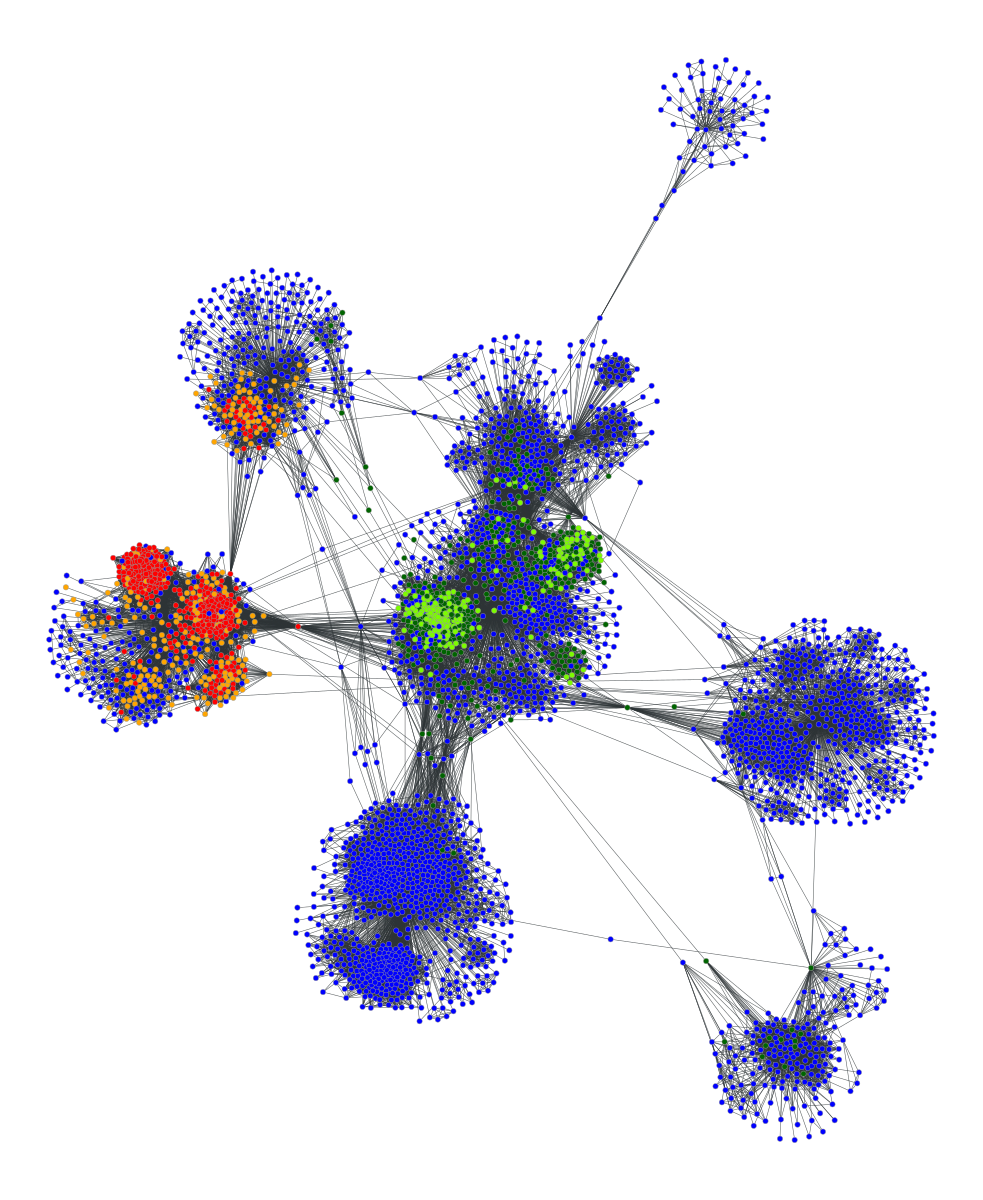

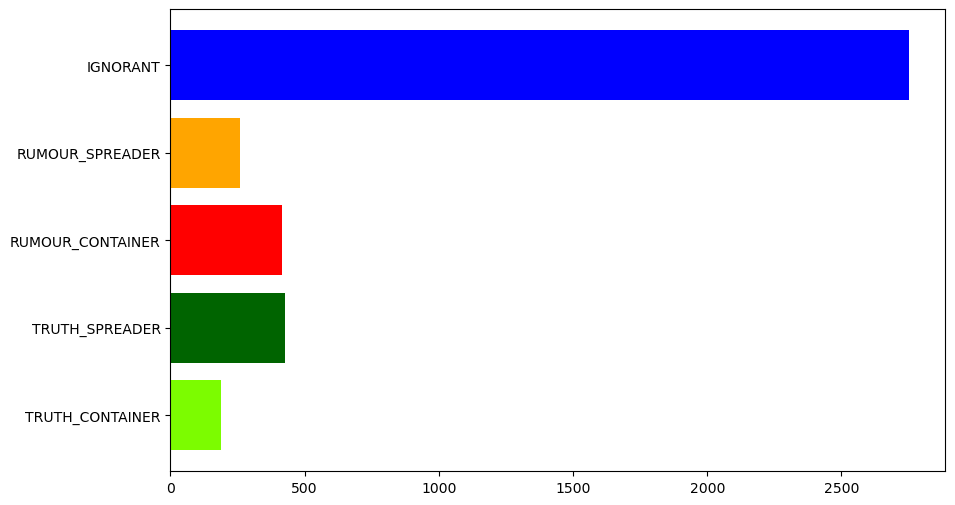

KeyboardInterrupt: 

In [16]:
# nx_graph = nx.barabasi_albert_graph(POPULATION_SIZE, CLIQUISHNESS)
nx_graph = nx.read_edgelist('datasets/facebook_combined.txt')

dk_model = DKModel(nx_graph, initial_rumour_spreaders=1, initial_truth_spreaders=1)
dk_model.run(TIME_STEPS, draw=True)

plt.figure(figsize=(10, 6))
for state in State:
    label = state.name.replace('_', ' ').title()
    plt.plot(dk_model.history[state], label=state.name, color=STATUS_COLOURS[state])
plt.title('DK Model of Rumor Propagation on a Graph')
plt.xlabel('Time Steps')
plt.ylabel('Number of Individuals')
plt.legend()
plt.show()



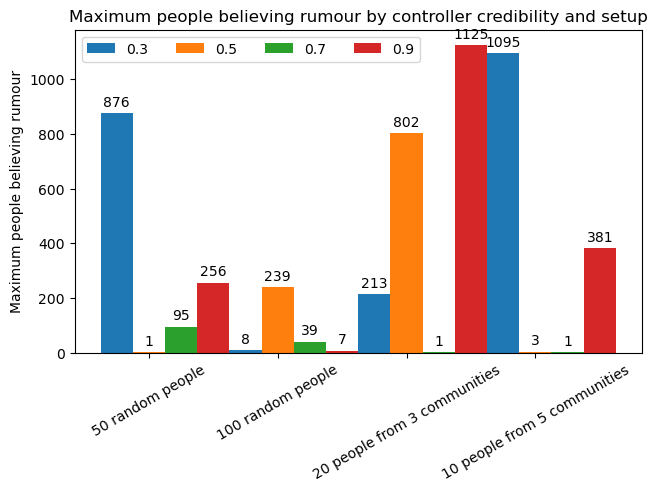

In [31]:
TRIALS = 1
CREDIBILITY_VALUES = [0.3, 0.5, 0.7, 0.9]

def setup_ccs(ccs: ControllerConnectionStrategies, ccs_random_nodes: int = None, ccs_communities_num: int = None, ccs_communities_size: int = None) -> None:
    global CONTROLLER_CONNECTION_STRATEGIES, CCS_RANDOM_NODES, CCS_COMMUNITIES_SIZE, CCS_COMMUNITIES_NUM
    CONTROLLER_CONNECTION_STRATEGIES = ccs
    CCS_RANDOM_NODES = ccs_random_nodes
    CCS_COMMUNITIES_NUM = ccs_communities_num
    CCS_COMMUNITIES_SIZE = ccs_communities_size

CCS_SETUP_FUNCTIONS = {
    "50 random people": lambda: setup_ccs(ControllerConnectionStrategies.RANDOM, ccs_random_nodes=50),
    "100 random people": lambda: setup_ccs(ControllerConnectionStrategies.RANDOM, ccs_random_nodes=100),
    "20 people from 3 communities": lambda: setup_ccs(ControllerConnectionStrategies.COMMUNITIES, ccs_communities_num=3, ccs_communities_size=20),
    "10 people from 5 communities": lambda: setup_ccs(ControllerConnectionStrategies.COMMUNITIES, ccs_communities_num=5, ccs_communities_size=10)
}

credibilities = {}
for credibility in CREDIBILITY_VALUES:
    credibilities[str(credibility)] = []
    for setup_name, setup_function in CCS_SETUP_FUNCTIONS.items():
        setup_function()

        # For a credibility and setup, run the model multiple times and record the average maximum rumour size
        max_rumour_size = []
        for _ in range(TRIALS):
            dk_model = DKModel(nx_graph, initial_rumour_spreaders=1, initial_truth_spreaders=1)
            dk_model.run(TIME_STEPS)
            max_rumour_size.append(max(dk_model.history[State.RUMOUR_SPREADER]))
        
        average_max_rumour_size = np.mean(max_rumour_size)
        credibilities[str(credibility)].append(average_max_rumour_size)

x = np.arange(len(CCS_SETUP_FUNCTIONS))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

# Plot the data into groups
for attribute, measurement in credibilities.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Set up the plot
ax.set_ylabel('Maximum people believing rumour')
ax.set_title('Maximum people believing rumour by controller credibility and setup')
ax.set_xticks(x + width, CCS_SETUP_FUNCTIONS.keys(), rotation=30)
ax.legend(loc='upper left', ncols=4)

plt.show()

In [13]:
# Run simulations to get the final rumour/truth sizes and max rumour/truth sizes
TRIALS = 10
final_rumour_sizes = []
final_truth_sizes = []
max_rumour_sizes = []
max_truth_sizes = []

for _ in range(TRIALS):
    dk_model = DKModel(nx_graph, initial_rumour_spreaders=1, initial_truth_spreaders=1)
    dk_model.run(TIME_STEPS)

    final_rumour_sizes.append(dk_model.history[State.RUMOUR_SPREADER][-1] + dk_model.history[State.RUMOUR_CONTAINER][-1])
    final_truth_sizes.append(dk_model.history[State.TRUTH_SPREADER][-1] + dk_model.history[State.TRUTH_CONTAINER][-1])
    max_rumour_sizes.append(max(dk_model.history[State.RUMOUR_SPREADER] + dk_model.history[State.RUMOUR_CONTAINER]))
    max_truth_sizes.append(max(dk_model.history[State.TRUTH_SPREADER] + dk_model.history[State.TRUTH_CONTAINER]))

def display_histogram(data, title):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=20, edgecolor='black')
    plt.title(title)
    plt.xlabel('Number of Individuals')
    plt.ylabel('Frequency')
    plt.show()

display_histogram(final_rumour_sizes, 'Final Rumour Sizes')
display_histogram(final_truth_sizes, 'Final Truth Sizes')
display_histogram(max_rumour_sizes, 'Max Rumour Sizes')
display_histogram(max_truth_sizes, 'Max Truth Sizes')

NameError: name 'graph' is not defined